In [2]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
model_name = 'test230410-02_LSTMJaponicaAll'

In [3]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test):
    X_pred = model.predict(X_test_shape)

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test, label='actual')  # x축에 년월일, y축에 값
    plt.plot(X_pred, color='red', label='prediction')  # x축에 년월일, y축에 시분
    plt.xlabel('날짜')
    plt.ylabel('DO')
    plt.title('시계열')
    plt.legend(['y_test','X_pred'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test)
    print("MSE // MAE // R-squared ", result)
    

In [4]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 훈련 데이터 시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

#자포니카 검증 데이터 시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

#자포니카 훈련 및 검증 데이터 시계열 변환
japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 날짜 데이터를 인덱스로 전환
japonica_training.set_index('mea_dt', inplace=True)
japonica_validation.set_index('mea_dt', inplace=True)

# 탱크 순으로 데이터 정렬
japonica_training.sort_values(by='tank_id', ascending=True, inplace=True)
japonica_validation.sort_values(by='tank_id', ascending=True, inplace=True)

# 인덱스 순으로 데이터를 정렬
#japonica_training = japonica_training.sort_index()
#japonica_validation = japonica_validation.sort_index()

japonica_training = japonica_training.groupby('tank_id').apply(lambda x: x.sort_index())
japonica_validation = japonica_validation.groupby('tank_id').apply(lambda x: x.sort_index())

In [5]:
# 사용할 features 선택
feature_origin = ['tank_id','do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

In [6]:
# 독립 변수, 종속 변수 분리
feature_Learning = ['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
feature_number = len(feature_Learning)

japonica_training_features_X = japonica_training_features[feature_Learning]
japonica_training_features_y = japonica_training_features[['do_mg']]
japonica_validation_features_X = japonica_validation_features[feature_Learning]
japonica_validation_features_y = japonica_validation_features[['do_mg']]

In [7]:
# LSTM학습을 위해 데이터 reshape를 해야함. reshape를 위해 배열형으로 변환
japonica_training_features_X_reshape = np.asarray(japonica_training_features_X, dtype=np.float64)
japonica_validation_features_X_reshape = np.asarray(japonica_validation_features_X, dtype=np.float64)

# 데이터를 3항으로 reshape. (batch_size, timesteps, features)
# batch_size: 한 번에 모델에 입력되는 샘플의 개수
# timesteps: 입력되는 시퀀스 데이터의 길이(시간축)
# features: 입력되는 데이터의 특성 개수
# 말이 어려우니까 쉽게 쓰면 (얼마 만큼의 샘플을, 시간 당 몇 개씩, 항목이 몇 개인가)
# (-1 : 있는 만큼의 샘플을, 1 : 시간당 1개씩, 8 : 피처는 8개입니다.)
japonica_training_features_X_reshape = japonica_training_features_X_reshape.reshape((-1, 1, feature_number))
japonica_validation_features_X_reshape = japonica_validation_features_X_reshape.reshape((-1, 1, feature_number))

In [8]:
# shape확인
nCar = japonica_training_features_X_reshape.shape[0] # 데이터 개수
nVar = japonica_training_features_X_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y.shape[0] # 데이터 개수
nVar = japonica_training_features_y.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = japonica_validation_features_X_reshape.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y.shape[0] # 데이터 개수
nVar = japonica_validation_features_y.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1113748 nVar: 8
nCar: 1113748 nVar: 1
nCar: 1113748 nVar: 8
nCar: 1113748 nVar: 1


In [9]:
# LSTM 모델 생성
model = Sequential()
# 결과값이 128개 -> 64개 -> 32개 -> 1개(회귀)
# input_shape=(timesteps, input_dim)
# timesteps : 시계열 데이터의 시간 스텝 수.
#       예를 들어, 1분 단위로 측정한 센서 데이터가 있다면 timesteps는 60.
# input_dim : 특성(feature)의 수.
model.add(LSTM(128, input_shape=(1, feature_number), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])

checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.

hist = model.fit(japonica_training_features_X_reshape, japonica_training_features_y, epochs = 200, batch_size = 64, validation_data=(japonica_validation_features_X_reshape, japonica_validation_features_y), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

2023-04-10 08:46:57.466255: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 08:46:57.855348: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            70144     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 132,001
Trainable params: 132,001
Non-trainable params: 0
_________________________________________________________________


2023-04-10 08:46:58.732962: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2023-04-10 08:47:02.665850: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200


    1/17403 [..............................] - ETA: 23:42:50 - loss: 63.7928 - mae: 7.6860 - r_squared: -12.5423

2023-04-10 08:47:03.534295: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


17403/17403 [==============================] - 318s 18ms/step - loss: 3.1272 - mae: 1.3768 - r_squared: 0.2818 - val_loss: 2.8136 - val_mae: 1.3119 - val_r_squared: -511496.7812
Epoch 2/200
17403/17403 [==============================] - 311s 18ms/step - loss: 2.6541 - mae: 1.2746 - r_squared: 0.3878 - val_loss: 2.5703 - val_mae: 1.2514 - val_r_squared: -575538.5000
Epoch 3/200
17403/17403 [==============================] - 314s 18ms/step - loss: 2.5310 - mae: 1.2338 - r_squared: 0.4156 - val_loss: 2.4338 - val_mae: 1.2099 - val_r_squared: -282698.9375
Epoch 4/200
17403/17403 [==============================] - 311s 18ms/step - loss: 2.4384 - mae: 1.2027 - r_squared: 0.4362 - val_loss: 2.4035 - val_mae: 1.1843 - val_r_squared: -423919.1250
Epoch 5/200
17403/17403 [==============================] - 311s 18ms/step - loss: 2.3612 - mae: 1.1778 - r_squared: 0.4540 - val_loss: 2.2885 - val_mae: 1.1612 - val_r_squared: -397266.9688
Epoch 6/200
17403/17403 [==============================] - 314

17403/17403 [==============================] - 310s 18ms/step - loss: 1.4832 - mae: 0.8739 - r_squared: 0.6552 - val_loss: 1.4789 - val_mae: 0.8728 - val_r_squared: -202148.3906
Epoch 44/200
17403/17403 [==============================] - 308s 18ms/step - loss: 1.4803 - mae: 0.8730 - r_squared: 0.6560 - val_loss: 1.4761 - val_mae: 0.8691 - val_r_squared: -191416.4688
Epoch 45/200
17403/17403 [==============================] - 313s 18ms/step - loss: 1.4783 - mae: 0.8715 - r_squared: 0.6565 - val_loss: 1.4702 - val_mae: 0.8693 - val_r_squared: -229327.4688
Epoch 46/200
17403/17403 [==============================] - 311s 18ms/step - loss: 1.4742 - mae: 0.8704 - r_squared: 0.6575 - val_loss: 1.4677 - val_mae: 0.8676 - val_r_squared: -205959.3438
Epoch 47/200
17403/17403 [==============================] - 308s 18ms/step - loss: 1.4723 - mae: 0.8695 - r_squared: 0.6578 - val_loss: 1.4694 - val_mae: 0.8674 - val_r_squared: -212160.7344
Epoch 48/200
17403/17403 [==============================] 

Epoch 85/200
17403/17403 [==============================] - 307s 18ms/step - loss: 1.4071 - mae: 0.8452 - r_squared: 0.6727 - val_loss: 1.4071 - val_mae: 0.8452 - val_r_squared: -208791.8125

Epoch 00085: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 86/200
17403/17403 [==============================] - 315s 18ms/step - loss: 1.4071 - mae: 0.8452 - r_squared: 0.6728 - val_loss: 1.4071 - val_mae: 0.8452 - val_r_squared: -208824.2500
Epoch 87/200
17403/17403 [==============================] - 313s 18ms/step - loss: 1.4071 - mae: 0.8452 - r_squared: 0.6730 - val_loss: 1.4071 - val_mae: 0.8452 - val_r_squared: -208825.8750
Epoch 00087: early stopping


In [10]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[ 1.24283440e-01  2.85025954e-01 -3.27398963e-02 ... -1.10691810e+00
   2.60139201e-02  2.10927859e-01]
 [ 5.87002337e-01  1.02850996e-01  8.26751471e-01 ...  2.49881887e+00
   1.72667683e-03  4.11479175e-02]
 [-3.10738776e-02  7.36445263e-02 -1.37922794e-01 ...  1.06519349e-01
   3.66394132e-01  1.51509896e-01]
 ...
 [ 1.80503204e-01  1.70041651e-01 -6.02991357e-02 ...  1.04903571e-01
   2.19143070e-02  3.50711793e-02]
 [-1.68298498e-01  1.32985180e-02  8.33430052e-01 ...  1.65544078e-01
   1.07369773e-01  3.71188447e-02]
 [-3.46547365e-02 -5.49853370e-02  7.58038938e-01 ... -1.05512403e-01
   7.26546571e-02  6.50715530e-02]]


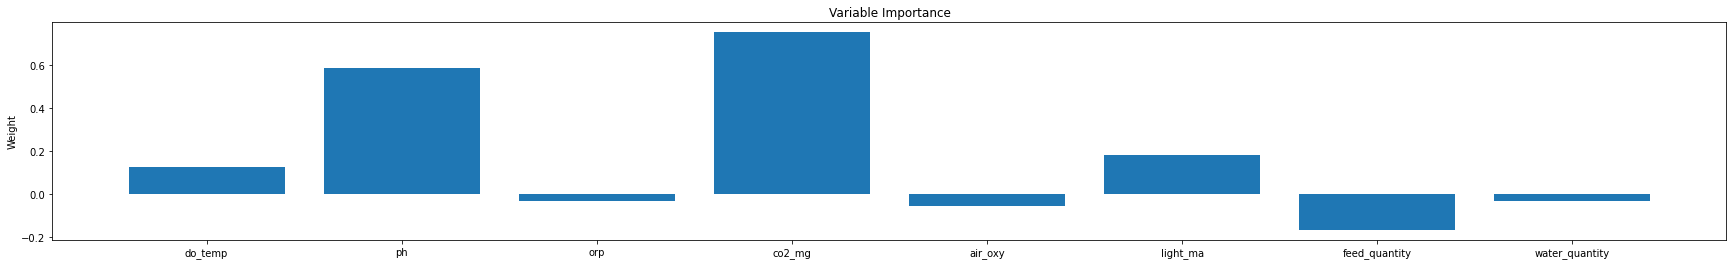

In [11]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(30, 4))
ax.bar(range(feature_number), weights[:, 0])
ax.set_xticks(range(feature_number))
ax.set_xticklabels(feature_Learning)
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

ValueError: setting an array element with a sequence.

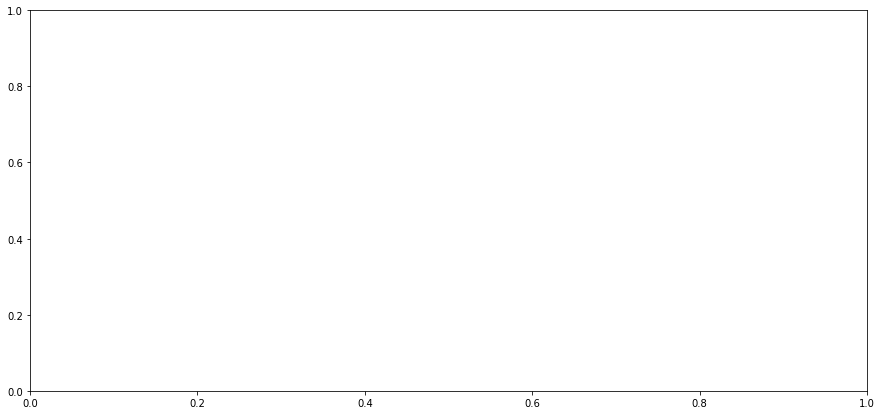

In [12]:
grapeNEva(model, japonica_validation_features_X_reshape, japonica_validation_features_y)

In [ ]:
# 자포니카 검증 데이터의 한 개 탱크
tank = 1
japonica_validation_features_tank = japonica_validation_features[japonica_validation_features['tank_id']==tank]

# 하루 동안의 데이터 추출
one_day_data = japonica_validation_features_tank.loc['2021-08-27 00:00:00':'2021-08-27 23:59:59']
oneday_X_test = one_day_data[feature_Learning]
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 1, feature_number))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test)